In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
from pandas.plotting import parallel_coordinates
import pytz, nltk
from pytz import common_timezones, all_timezones

import scipy as sp
import scipy.stats as stats
import pylab



import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
matplotlib.style.use('seaborn-talk')
matplotlib.style.use('fivethirtyeight');


import scipy
import os
import plotly
plotly.offline.init_notebook_mode(connected=True)

import sqlite3
import plotly.express as px

import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

import keras
from keras import layers
from keras.layers import Dense, Dropout
from keras.models import Sequential
import keras.regularizers as regularizers
from keras import optimizers

import keras
from keras.layers import Dense, Dropout
from keras.models import Sequential
import keras.regularizers as regularizers
from keras import optimizers


# Load in Needed Objects

In [2]:
from keras.models import model_from_json
from keras.models import model_from_yaml
from pickle import load
from pickle import dump
import sqlite3
from keras.models import load_model

In [3]:
model = load_model('model_notime.h5')
scaler_xtrain = load(open('scaler_xtrain_notime.pkl','rb'))

with sqlite3.connect('turbofandata.db') as connection:
    dfval = pd.read_sql('SELECT * from dfval_notime', connection)
    dftrain = pd.read_sql('SELECT * from dftrain', connection)
    dftest = pd.read_sql('SELECT * from dftest', connection)

# Survival Curves

In [4]:
#input_cols = ['time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
#       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
#       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
#       's_21']

input_cols = ['setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21']


#output_cols = ['breakdown']
output_cols = ['label']

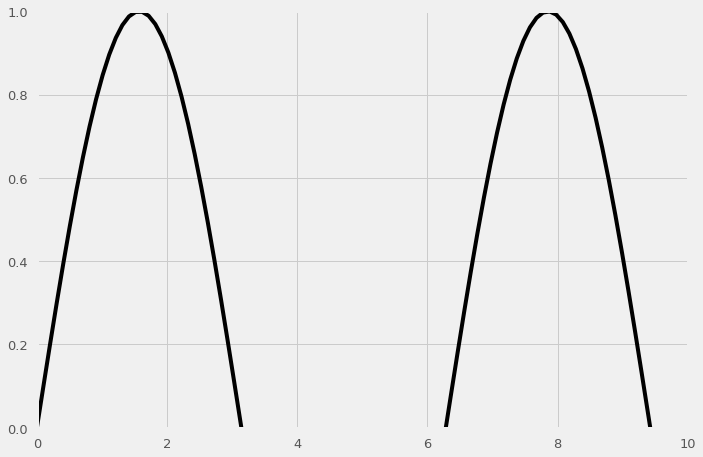

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

x = np.linspace(0, 10, 100)
y = np.sin(x)

fig, ax = plt.subplots()
line, = ax.plot(x, y, color='k')

def update(num, x, y, line):
    line.set_data(x[:num], y[:num])
    line.axes.axis([0, 10, 0, 1])
    return line,

ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=25, blit=True)
ani.save('test.mp4')
#plt.show()

In [7]:
try:
    os.mkdir('ANIMATEDSURVIVALCURVES')
except:
    pass

In [6]:
dfval.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_16,s_17,s_18,s_19,s_20,s_21,RUL,breakdown,id,label
0,3,1,0.0008,0.0005,100.0,518.67,642.04,1584.20,1398.13,14.62,...,0.03,391,2388,100.0,38.96,23.3205,178,0,3fd_001,0
1,3,2,-0.0010,0.0000,100.0,518.67,642.66,1587.04,1398.62,14.62,...,0.03,390,2388,100.0,39.07,23.4369,177,0,3fd_001,0
2,3,3,0.0013,-0.0002,100.0,518.67,642.07,1580.75,1401.10,14.62,...,0.03,393,2388,100.0,39.03,23.3162,176,0,3fd_001,0
3,3,4,0.0008,-0.0002,100.0,518.67,642.50,1580.12,1395.76,14.62,...,0.03,391,2388,100.0,38.94,23.4901,175,0,3fd_001,0
4,3,5,0.0020,0.0004,100.0,518.67,641.97,1581.48,1394.05,14.62,...,0.03,391,2388,100.0,38.90,23.4190,174,0,3fd_001,0


In [15]:
def get_survival_function(identifier,dfval,input_cols,
                          scaler_xtrain, clf, make_plot = True, SHOW=True,
                         AUTO_OPEN=False):
    """Takes the input array X and the trained model.
    returns the predicted survival function."""
    X_0 = scaler_xtrain.transform(dfval[dfval.id == identifier][input_cols].to_numpy())
    #real_rul = dfval[dfval.id == identifier]['REAL_RUL']
    #print(X_0)
    hazards = clf.predict(X_0)
    A = []
    p_so_far = 1
    for i in range(len(hazards)):
        p_cur = hazards[i][0]
        A.append(p_so_far*(1 - p_cur))
        p_so_far = p_so_far*(1 - p_cur)
    As = pd.Series(A)
    As.name = identifier
    
    try:
        dq = dfval[dfval.id == identifier].copy()
        red = dq.groupby('label')['time_cycles'].min()
        t_red = red.loc[1] # the time_cycles value at which to add a red vertical line
    except:
        pass
    if make_plot:
        fig = px.line(As, title=f"survival curve for {identifier}")
        try:
            fig.update_layout(shapes=[
                   dict(
                   type='line',name='actual TTF start',
                   yref='paper', y0=0, y1=1,
                   xref='x', x0=t_red, x1=t_red)
               ])
            plotly.offline.plot(fig,auto_open=AUTO_OPEN,
                filename=f"ANIMATEDSURVIVALCURVES/survival{identifier}.html")
        except:
            pass
        if SHOW:
            fig.show()
    df = pd.DataFrame(scaler_xtrain.inverse_transform(X_0), columns=input_cols)
    df['As'] = As
    df['hazard'] = [h[0] for h in hazards]
    # capture the information of when it really started to fail
    df['TRUE_START_OF_BREAKDOWN'] = t_red
    df.name = f"{identifier}"
    filename=f"ANIMATEDSURVIVALCURVES/survival{identifier}.csv"
    df['As'] = As
    df.to_csv(filename,index=False)
    
    dg = pd.DataFrame(X_0, columns=input_cols)
    dg['As'] = As
    dg['hazard'] = [h[0] for h in hazards]
    dg.name = f"{identifier}"
    #
    #x = df['time_cycles'].to_numpy()
    x = df.reset_index().index
    y = df['As'].to_numpy()


    fig, ax = plt.subplots()
    line, = ax.plot(x, y, color='k')

    def update(num, x, y, line):
        line.set_data(x[:num], y[:num])
        #line.axes.axis([0, df['time_cycles'].max(), 0, df['As'].max()+.05])
        line.axes.axis([0, x.max(), 0, df['As'].max()+.05])
        return line,

    ani = animation.FuncAnimation(fig, update, len(x), fargs=[x, y, line],
                              interval=25, blit=True)

    ani.save(f'ANIMATEDSURVIVALCURVES/{df.name}.mp4')
    return df, dg

In [16]:
valids = dfval['id'].unique()

In [17]:
len(valids)

177

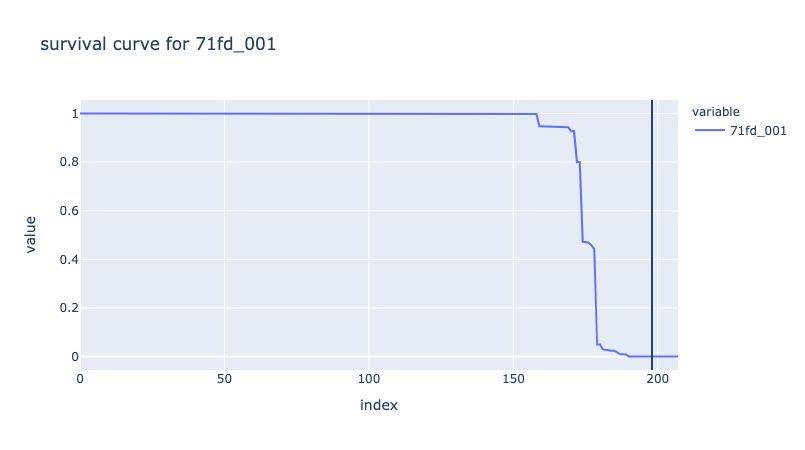

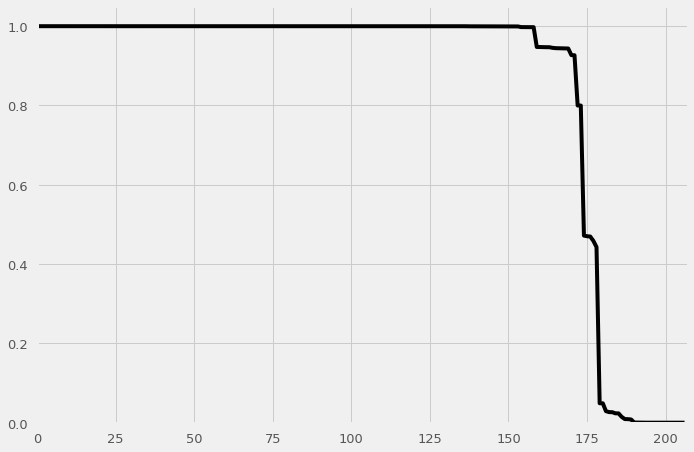

In [18]:
df, dg = get_survival_function(valids[15], dfval, input_cols,
                               scaler_xtrain, model,
                              SHOW=True, AUTO_OPEN=False)

In [19]:
df.head()

,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,s_6,s_7,...,s_15,s_16,s_17,s_18,s_19,s_20,s_21,As,hazard,TRUE_START_OF_BREAKDOWN
0,0.0027,-0.0004,100.0,518.67,642.64,1581.95,1407.04,14.62,21.61,553.56,...,8.4372,0.03,391.0,2388.0,100.0,38.99,23.2399,1.0,1.985548e-09,198
1,0.0029,-0.0003,100.0,518.67,642.82,1593.17,1403.53,14.62,21.61,553.22,...,8.4068,0.03,392.0,2388.0,100.0,38.85,23.2887,1.0,4.687378e-09,198
2,0.0007,0.0003,100.0,518.67,642.50,1582.94,1402.54,14.62,21.61,553.70,...,8.4233,0.03,394.0,2388.0,100.0,38.92,23.3668,1.0,1.488603e-08,198
3,-0.0014,0.0003,100.0,518.67,643.04,1584.90,1409.75,14.62,21.61,554.30,...,8.4352,0.03,392.0,2388.0,100.0,38.89,23.2722,1.0,6.211212e-09,198
4,0.0015,0.0001,100.0,518.67,642.00,1587.63,1400.43,14.62,21.61,553.49,...,8.4395,0.03,393.0,2388.0,100.0,39.03,23.2896,1.0,2.312432e-09,198


Now animate the line plot of **df** As vs time_cyles

In [20]:
df.name


'71fd_001'

In [21]:
from tqdm import tqdm

Uncomment the cell below to create the animated figures and survival curve data for the 
validation set.

In [23]:
#for idv in tqdm(valids):
#    df, dg = get_survival_function(idv, dfval, input_cols,
#                               scaler_xtrain, model,
#                              SHOW=False, AUTO_OPEN=False)

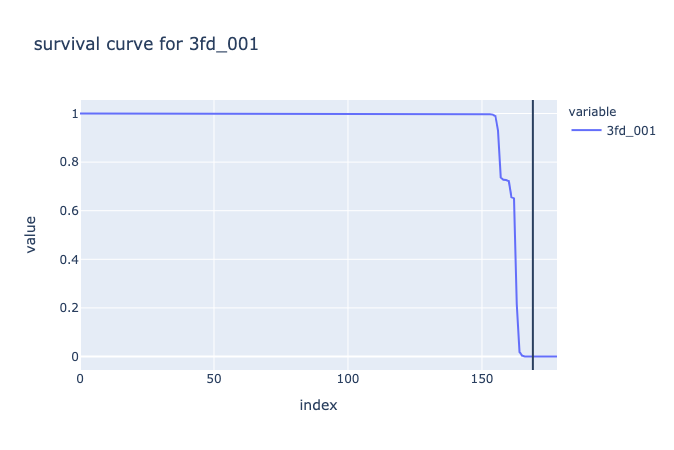

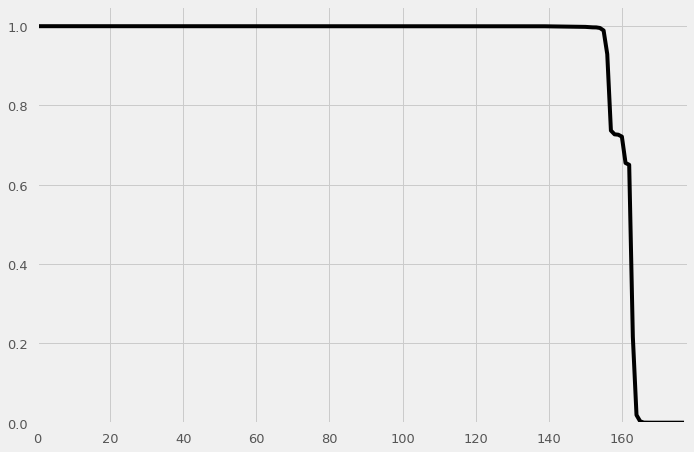

In [24]:
df, dg = get_survival_function(valids[0], dfval, input_cols,
                               scaler_xtrain, model)

# Investigate where the model is jumping the gun (by how much)

In [25]:
dfval.columns

Index(['unit_nr', 'time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21', 'RUL', 'breakdown', 'id', 'label'],
      dtype='object')

In [26]:
TTF = 10
predicted = pd.DataFrame(index=dfval.index)
X_val = scaler_xtrain.transform(dfval[input_cols].to_numpy())
yhat_classes = (model.predict(X_val, verbose=0) > 0.5).astype("int32") 

predicted['NN'] = model.predict(scaler_xtrain.transform(dfval[input_cols].to_numpy()))
predicted['NN'] = yhat_classes
predicted['RUL'] = dfval['RUL']
predicted['true_label'] = np.where(predicted['RUL'] <= TTF, 1, 0)
predicted['id'] = dfval['id']

FN = predicted[(predicted['true_label'] != predicted['NN']) & \
              (predicted['NN'] == 0)]
FN.describe()


,NN,RUL,true_label
count,50.0,50.000000,50.0
mean,0.0,8.540000,1.0
std,0.0,1.431568,0.0
min,0.0,4.000000,1.0
25%,0.0,8.000000,1.0
50%,0.0,9.000000,1.0
75%,0.0,10.000000,1.0
max,0.0,10.000000,1.0


The above shows that there was never a false negative within 3 time units of the actual failure.

All the false negatives occurred for 4 <= RUL <= 10.

In [27]:
FP = predicted[(predicted['true_label'] != predicted['NN']) & \
              (predicted['NN'] == 1)]
FP.describe()


,NN,RUL,true_label
count,1515.0,1515.000000,1515.0
mean,1.0,19.248845,0.0
std,0.0,9.512253,0.0
min,1.0,11.000000,0.0
25%,1.0,13.000000,0.0
50%,1.0,17.000000,0.0
75%,1.0,22.000000,0.0
max,1.0,83.000000,0.0


<AxesSubplot:>

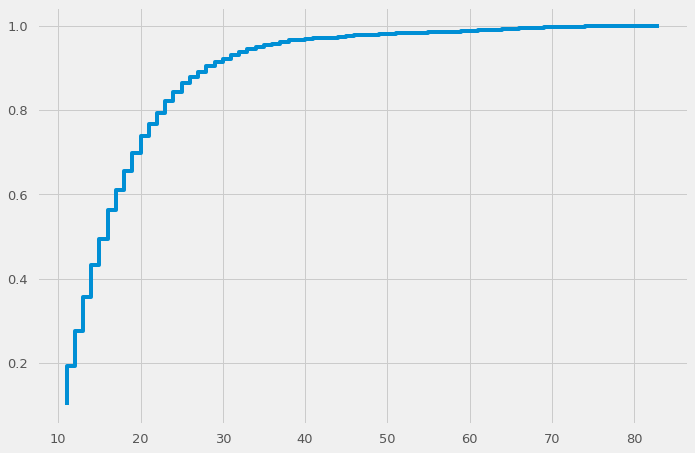

In [28]:
FP['RUL'].value_counts(normalize=True).sort_index().cumsum().plot(drawstyle='steps')


In [29]:
fp_cdf = FP['RUL'].value_counts(normalize=True).sort_index().cumsum()
fp_cdf.head(15)


11    0.100990
12    0.192739
13    0.275908
14    0.356436
15    0.431683
16    0.494389
17    0.561716
18    0.610561
19    0.655446
20    0.699010
21    0.737954
22    0.767657
23    0.794059
24    0.821782
25    0.841584
Name: RUL, dtype: float64

85 \% of the false positives occurred where the RUL <= 25.  So even when it jumps the gun, its not wasting your time.

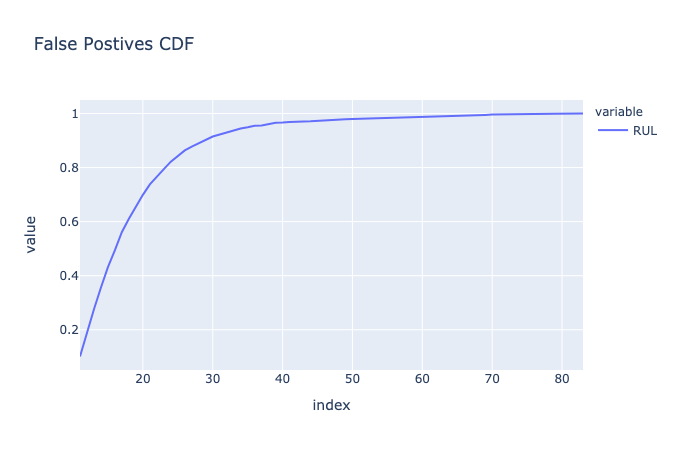

In [30]:
import plotly.express as px
fig = px.line(fp_cdf,
             title='False Postives CDF')
plotly.offline.plot(fig, filename='false_positives.html')
fig.show()


In [31]:
import umap


question: do you need to scale the data first with a StandardScaler, or can you just apply 
umap directly?  you need to scale.

In [32]:
dftrain.shape

(160359, 29)

In [33]:
try:
    os.mkdir('UMAPPLOTS_ANIMATED')
except:
    pass

In [34]:
#from plotly import Layout

In [35]:
def make_umap_plot(df,goodcols,n_components,n_neighbors=5,SHOW=False,
                  WITH_TIME=True,AUTO_OPEN=True):
    """dimensionally reduces df using UMAP to n_components dimensions and renders a
    n_componenet (2 or 3) - dimesional interactive plot
    with plotly, where the point is colored
    according to its RUL value"""
    
    plot_bgcolor='rgba(0,0,0,0)'
                        
    

    dg = df.copy()
    umap_scaler = StandardScaler()
    umap_scaler.fit(dg[goodcols])
    reducer = umap.UMAP(n_neighbors=n_neighbors,
                       n_components=n_components,
                       random_state=42)
    X_embedded = reducer.fit_transform(umap_scaler.transform(dg[goodcols]))
    
    dq = pd.DataFrame(X_embedded, index=dg.index)
    dq['RUL'] = dg['RUL']
    dr = pd.concat([dq,dg[goodcols]],axis=1)
    dc = dr
    if WITH_TIME:
        #title = '{} dimensional UMAP plot with time'.format(n_components)
        title = f'{n_components} {n_neighbors} neighbors UMAP plot with time' 
        filename=f"UMAPPLOTS_ANIMATED/umap_{n_components}_{n_neighbors}_neighbors_with_time.html"
    else:
        title = f'{n_components} {n_neighbors} neighbors dimensional UMAP plot'
        filename=f"UMAPPLOTS_ANIMATED/umap_{n_components}_{n_neighbors}_neighbors.html"
    csv_name = filename.replace('.html','.csv')
    if n_components == 2:
        fig = px.scatter(dc, x=0,y=1,
                color='RUL',
                color_continuous_scale = px.colors.sequential.Rainbow,
                 range_color = (dc.RUL.min(),dc.RUL.max()),
                hover_data = goodcols,
                title=title,
                marginal_y="violin",
                marginal_x="violin",
                )
        fig.update_layout(dict(plot_bgcolor = '#000000'))
        fig.update_layout(dict(paper_bgcolor = '#000000'))
        fig.update_layout(title=dict(text=title,
                                     font=dict(color='rgba(255,255,0,1)')))
        fig.update_yaxes(showgrid=False, zeroline=False)
        fig.update_xaxes(showgrid=False, zeroline=False)
        fig.update_layout(dict())
        plotly.offline.plot(fig, filename=filename,auto_open=AUTO_OPEN)
        #fig.update_layout(legend = dict(plot_bgcolor = 'rgba(0,0,0,0)'))
        if SHOW:
            fig.show()
        dc.to_csv(csv_name, index=False)
    elif n_components == 3:
        fig = px.scatter_3d(dc, x=0,y=1,z=2,
                color='RUL',
                color_continuous_scale = px.colors.sequential.Rainbow,
                 range_color = (dc.RUL.min(),dc.RUL.max()),
                title=title,
                hover_data = goodcols,
                )
        fig.update_layout(dict(plot_bgcolor = '#000000'))  
        fig.update_layout(dict(paper_bgcolor = '#000000'))
        fig.update_layout(title=dict(text=title,
            font=dict(color='rgba(255,255,0,1)')))
        fig.update_yaxes(showgrid=False, zeroline=False)
        fig.update_xaxes(showgrid=False, zeroline=False)
        plotly.offline.plot(fig, filename=filename,auto_open=AUTO_OPEN)
        if SHOW:
            fig.show()
        dc.to_csv(csv_name, index=False)
    
    return dc, umap_scaler, reducer, goodcols, csv_name # return the dimensionally reduced dataframe
        

In [36]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install celluloid

UMAP tutorial: https://umap-learn.readthedocs.io/en/latest/
plotly animations: https://towardsdatascience.com/how-to-create-animated-visualizations-with-plotly-c54b9c97b133

Understanding the image processing capabilities (and deficits!) of modern convolutional neural networks is a challenge. Certainly these models are capable of amazing feats in, for example, image classification. They can also be brittle in unexpected ways, with carefully designed images able to induce otherwise baffling mis-classifications. To better understand this researchers from Google and OpenAI built the activation atlas – analysing the space of activations of a neural network. Here UMAP provides a means to compress the activation landscape down to 2 dimensions for visualization. The result was an impressive interactive paper in the Distill journal, providing rich visualizations and new insights into thw working of convolutional neural networks.

SciPy 2018 UMAP

metric learning

UMAP for pandas dataframes!

https://github.com/lmcinnes/umap

conda install -c conda-forge umap-learn

leland mciness

leland.mcinnes@gmail.com



## Question

should **time_cycles** be included in the umap projections? I am not sure.

https://holoviews.org/getting_started/Gridded_Datasets.html

http://holoviews.org/getting_started/Live_Data.html

create a database with the data that needs to be plotted so its all ready to go.

https://www.drugabuse.gov/sites/default/files/overdose_data_1999-2015.xls

# Parallel Coordinates Plot

First embed the training data with UMAP into a 5 dimensional space:

need to keep track of two transfomrations

* umap_scaler , a StandardScaler object
* reducer , the actual UMAP transformation; the space where the parallel coordinates plots will be made

Geometric approach to interpretation , building intuition and trust.

In the right space, the different classes are clearly separable

embed on a torus:

https://github.com/lmcinnes/umap/pull/103


https://github.com/lmcinnes/umap/tree/master/examples

https://github.com/lmcinnes/umap/blob/master/examples/mnist_torus_sphere_example.py

https://medium.com/@andreaolivato/how-to-solve-the-invalid-active-developer-path-brew-error-after-updating-to-mac-os-catalina-10-15-e351e743dd23

In [37]:
# Install a pip package in the current Jupyter kernel
import sys
#!{sys.executable} -m pip install PyQt5
#sys.executable} -m pip uninstall PySide2
#!{sys.executable} -m pip install mayavi
#!{sys.executable} -m pip install -U apptools
#!{sys.executable} -m pip install opencv-python-headless
#!{sys.executable} -m pip install ipyevents

```
Most likely you do not have a GUI toolkit installed into your environment. You need to have one of PyQt, PySide2 or wxPython (version 3.x, currently) installed.
```

In [38]:
#!python realscript.py

In [39]:
#!python scriptreal.py

https://christophm.github.io/interpretable-ml-book/neural-networks.html

https://github.com/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb

Make a parallel coordinates plot, color coded by ```label```

need both 

* reducer
* umap_scaler

so the 3rd component seems very discriminating:

Virtually every instance where coordinate 3 in the UMAP space was < ~ -2 is fully operational, 
independent of everything else

https://plotly.com/python/parallel-coordinates-plot/

In [40]:
#px.colors.diverging.

In [41]:
import plotly.express as px
#fig = px.parallel_coordinates(dfreduced, color='label',
#                color_continuous_scale=px.colors.diverging.Tealrose)
#fig.show()

Parallel coordinates are richly interactive by default. Drag the lines along the axes to filte regions.

so on the second axis , cooridnate 1 in the reduced space. everything 5 and below is fine. whereas 5 and above is a 1! very simple rule. then translate that info back into the orginal space to see what it means there. Grab those corresponding records and see what it a descriptive statistics analysis yields.

# Parallel Coordiantes Plots

In [42]:
from keras.models import model_from_json
from keras.models import model_from_yaml
from pickle import load
from pickle import dump
import sqlite3
from keras.models import load_model

In [43]:
model = load_model('model_notime.h5')
scaler_xtrain = load(open('scaler_xtrain_notime.pkl','rb'))

with sqlite3.connect('turbofandata.db') as connection:
    dfval = pd.read_sql('SELECT * from dfval_notime', connection)
    dftrain = pd.read_sql('SELECT * from dftrain', connection)
    dftest = pd.read_sql('SELECT * from dftest', connection)

In [44]:
#input_cols = ['time_cycles', 'setting_1', 'setting_2', 'setting_3', 's_1',
#       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
#       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
#       's_21']

input_cols = ['setting_1', 'setting_2', 'setting_3', 's_1',
       's_2', 's_3', 's_4', 's_5', 's_6', 's_7', 's_8', 's_9', 's_10', 's_11',
       's_12', 's_13', 's_14', 's_15', 's_16', 's_17', 's_18', 's_19', 's_20',
       's_21']
#output_cols = ['breakdown']
output_cols = ['label']

In [45]:
dfval.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_16,s_17,s_18,s_19,s_20,s_21,RUL,breakdown,id,label
0,3,1,0.0008,0.0005,100.0,518.67,642.04,1584.20,1398.13,14.62,...,0.03,391,2388,100.0,38.96,23.3205,178,0,3fd_001,0
1,3,2,-0.0010,0.0000,100.0,518.67,642.66,1587.04,1398.62,14.62,...,0.03,390,2388,100.0,39.07,23.4369,177,0,3fd_001,0
2,3,3,0.0013,-0.0002,100.0,518.67,642.07,1580.75,1401.10,14.62,...,0.03,393,2388,100.0,39.03,23.3162,176,0,3fd_001,0
3,3,4,0.0008,-0.0002,100.0,518.67,642.50,1580.12,1395.76,14.62,...,0.03,391,2388,100.0,38.94,23.4901,175,0,3fd_001,0
4,3,5,0.0020,0.0004,100.0,518.67,641.97,1581.48,1394.05,14.62,...,0.03,391,2388,100.0,38.90,23.4190,174,0,3fd_001,0


In [46]:
def get_all_paraplot(df,SHOW=False):
    dq = df[input_cols + ['RUL']].copy()
    fig = px.parallel_coordinates(dq,
                color='RUL',title=f"parallel_rul",
            color_continuous_scale=px.colors.
                                  diverging.Tealrose)
    plotly.offline.plot(fig, auto_open=True,
                   filename=f"parallel_rul.html")
    if SHOW:
        fig.show()
    

In [47]:
train_ids = dftrain['id'].unique()
train_ids[5]

'6fd_001'

In [48]:
#get_all_paraplot(pd.concat([dftrain,dfval]))
get_all_paraplot(dftrain,SHOW=False)